In [1]:
def fixed_to_float(val: int, nfrac: int, nbits: int, signed: False) -> float:
    """Convert fixed-point integer to float."""
    if signed:
        if val & (1 << (nbits - 1)):
            val -= (1 << nbits)
            print("HELLO")
    return val / (1 << nfrac)

In [2]:
hex = -512
fixed_to_float(hex, nfrac=10, nbits=16, signed=True)


HELLO


-64.5

In [3]:
0b11111_10100

1012

In [4]:
hex = 0xda65
fixed_to_float(hex, nfrac=10, nbits=18, signed=True)

54.5986328125

In [5]:
class ROM():
    def __init__(self, dat_path: str, input_data_fmt="16_10", address_fmt="10_4", table_data_fmt="18_10", table_data_signed=False):
        
        with open(dat_path, "r") as f:
            lines = f.readlines()
            
        self.dat = [int(line, 16) for line in lines]
        self.input_width = int(input_data_fmt.split("_")[0])
        self.input_frac = int(input_data_fmt.split("_")[1])
        self.address_width = int(address_fmt.split("_")[0])
        self.address_frac = int(address_fmt.split("_")[1])
        self.table_data_width = int(table_data_fmt.split("_")[0])
        self.table_data_frac = int(table_data_fmt.split("_")[1])
        self.table_data_signed = table_data_signed
        
    
    def _to_signed(self, val: int, width: int, n_frac:int) -> int:
        """Interpret val as a signed integer of given bit width"""
        output = val
        
        if val >= 2 ** (width - 1):
            output = val - 2 ** width
            
        output = output / (2 ** n_frac)
        return output

    def _fixed_to_float(self, val: int, total_bits: int, frac_bits: int, signed=True) -> float:
        """Convert fixed-point integer to float"""
        if signed:
            val = self._to_signed(val, total_bits, n_frac=frac_bits)
            return val
        return val / (2 ** frac_bits)

    def lookup(self, input_data: int, debug=False) -> float:
        if not isinstance(input_data, int):
            raise TypeError("input_data must be an integer. Got: {}".format(type(input_data)))

        # Interpret input as signed fixed-point
        signed_input = self._to_signed(input_data, self.input_width, self.input_frac)

        # If input is negative, interpret as fixed-point
        # If input is positive, interpret as integer (ignore fractional bits)
        if signed_input < 0:
            float_val = signed_input
            scaled_index = int(float_val * (2 ** self.address_frac))
        else:
            float_val = signed_input * 1.0  # no fractional scaling
            scaled_index = int(float_val)

        # Scale to address index
        scaled_index = int(signed_input * (2 ** self.address_frac))
        

        # Clip or wrap index to ROM size
        rom_index = scaled_index & ((1 << self.address_width) - 1)

        # Lookup value
        table_val = self.dat[rom_index]
        
        output = self._fixed_to_float(table_val, self.table_data_width, self.table_data_frac, signed=self.table_data_signed)
        
        if debug:
            print(f"Input data: {input_data}, Signed input: {signed_input}, float val: {float_val}, Scaled index: {scaled_index}, ROM index: {rom_index}, Table value: {table_val}, Output: {output}")

        # Convert output to float if needed
        return output
        
        
        

In [6]:
exp_rom: ROM = ROM(
    dat_path="/home/donovan/code/research/hls4ml/waiz-khan-files/model_7/16_10_prj/myproject_prj/solution1/impl/verilog/softmax_stable_ap_fixed_ap_fixed_16_10_5_3_0_softmax_config16_s_exp_table1_rom.dat",
    input_data_fmt="16_10",
    address_fmt="10_0",
    table_data_fmt="18_10",
    table_data_signed=False
)

print(exp_rom.lookup(0b010000_11111_00000, debug=True))

Input data: 17376, Signed input: 16.96875, float val: 16.96875, Scaled index: 16, ROM index: 16, Table value: 131071, Output: 127.9990234375
127.9990234375


Input data: -32768, Signed input: -32.0, float val: -32.0, Scaled index: -32, ROM index: 992, Table value: 0, Output: 0.0
Input data: -32704, Signed input: -31.9375, float val: -31.9375, Scaled index: -31, ROM index: 993, Table value: 0, Output: 0.0
Input data: -32640, Signed input: -31.875, float val: -31.875, Scaled index: -31, ROM index: 993, Table value: 0, Output: 0.0
Input data: -32576, Signed input: -31.8125, float val: -31.8125, Scaled index: -31, ROM index: 993, Table value: 0, Output: 0.0
Input data: -32512, Signed input: -31.75, float val: -31.75, Scaled index: -31, ROM index: 993, Table value: 0, Output: 0.0
Input data: -32448, Signed input: -31.6875, float val: -31.6875, Scaled index: -31, ROM index: 993, Table value: 0, Output: 0.0
Input data: -32384, Signed input: -31.625, float val: -31.625, Scaled index: -31, ROM index: 993, Table value: 0, Output: 0.0
Input data: -32320, Signed input: -31.5625, float val: -31.5625, Scaled index: -31, ROM index: 993, Table value: 0, Ou

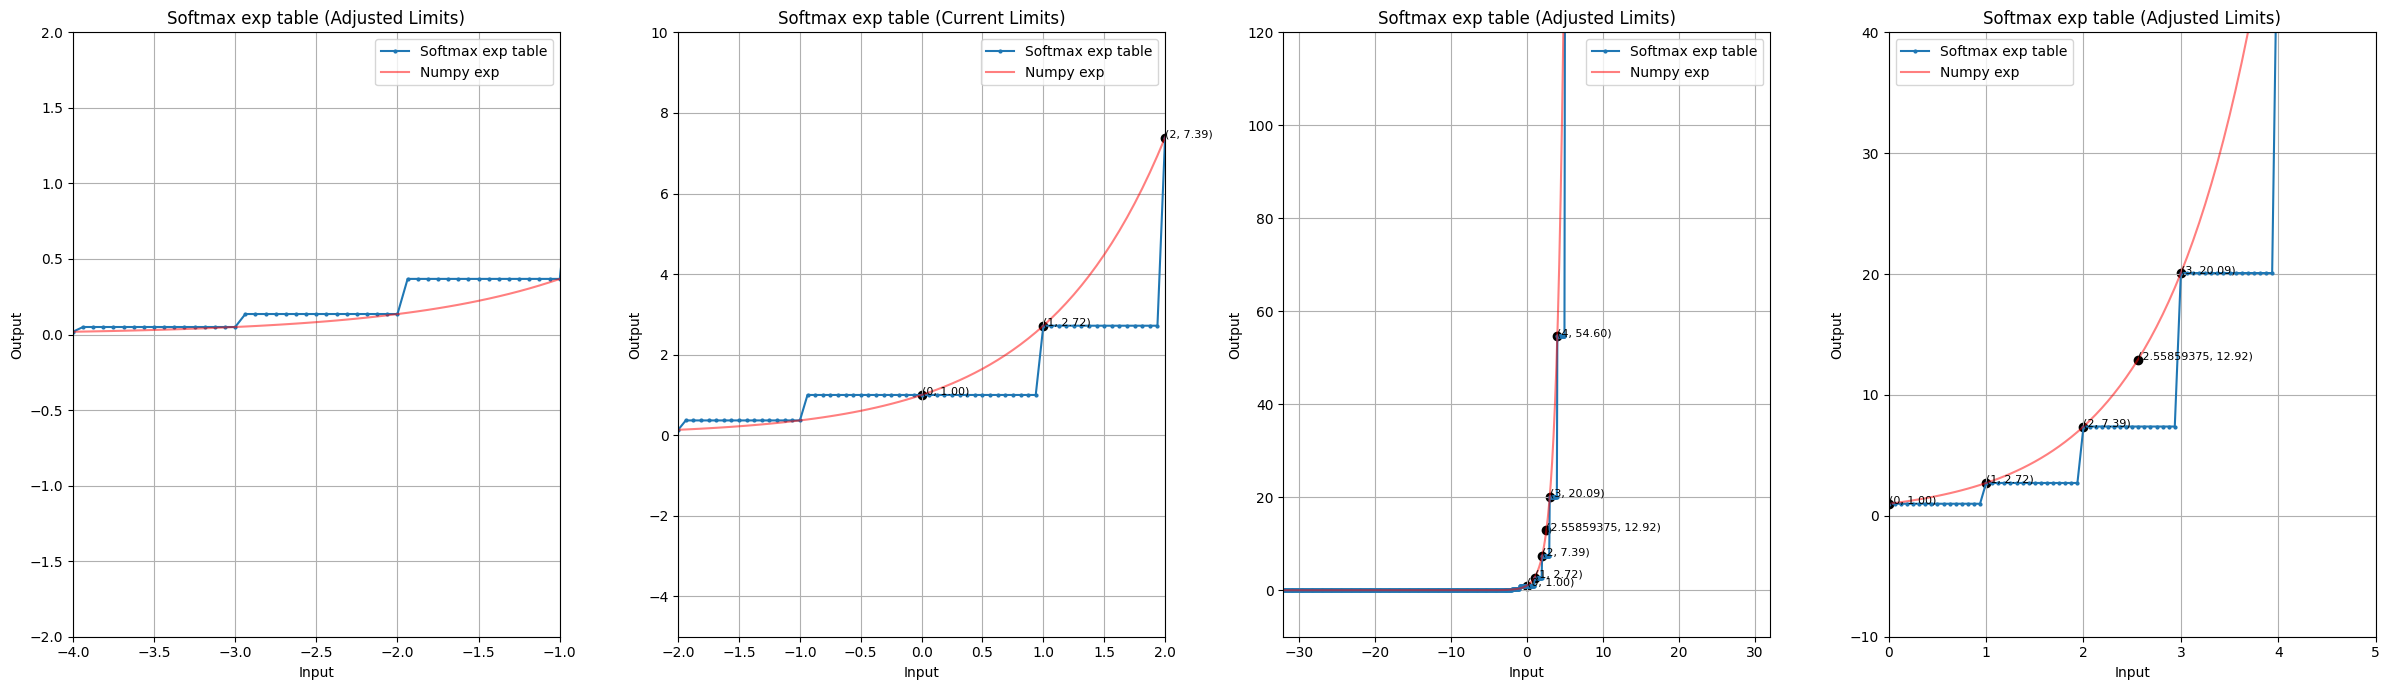

In [7]:
# plot all the values representable by 16_10
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-2**9, 2**9)
x = x * 2 ** 6
y = [exp_rom.lookup(int(i), debug=True) for i in x]

x_proper = x / (2**10)
fig, axs = plt.subplots(1, 4, figsize=(24, 7))

# Plot with adjusted x and y limits
axs[0].plot(x_proper, y, label="Softmax exp table", marker="o", markersize=2)
axs[0].plot(x_proper, np.exp(x_proper), label="Numpy exp", color="red", alpha=0.5)
axs[0].legend()
axs[0].set_title("Softmax exp table (Adjusted Limits)")
axs[0].grid()
axs[0].set_ylim(-2, 2)
axs[0].set_xlim(-4, -1)
axs[0].set_xlabel("Input")
axs[0].set_ylabel("Output")

# Plot with current x and y limits
axs[1].plot(x_proper, y, label="Softmax exp table", marker="o", markersize=2)
axs[1].plot(x_proper, np.exp(x_proper), label="Numpy exp", color="red", alpha=0.5)
axs[1].legend()
axs[1].set_title("Softmax exp table (Current Limits)")
axs[1].grid()
axs[1].set_ylim(-5, 10)
axs[1].set_xlim(-2, 2)
axs[1].set_xlabel("Input")
axs[1].set_ylabel("Output")

# Plot with adjusted x and y limits
axs[2].plot(x_proper, y, label="Softmax exp table", marker="o", markersize=2)
axs[2].plot(x_proper, np.exp(x_proper), label="Numpy exp", color="red", alpha=0.5)
axs[2].legend()
axs[2].set_title("Softmax exp table (Adjusted Limits)")
axs[2].grid()
axs[2].set_ylim(-10, 120)
axs[2].set_xlim(-32, 32)
axs[2].set_xlabel("Input")
axs[2].set_ylabel("Output")

# Plot with adjusted x and y limits
axs[3].plot(x_proper, y, label="Softmax exp table", marker="o", markersize=2)
axs[3].plot(x_proper, np.exp(x_proper), label="Numpy exp", color="red", alpha=0.5)
axs[3].legend()
axs[3].set_title("Softmax exp table (Adjusted Limits)")
axs[3].grid()
axs[3].set_ylim(-10, 40)
axs[3].set_xlim(0, 5)
axs[3].set_xlabel("Input")
axs[3].set_ylabel("Output")

x_points = [0, 1, 2, 3, 4, 2.55859375]
y_points = np.exp(x_points)

for i, (x_val, y_val) in enumerate(zip(x_points, y_points)):
    
    for ax in axs:
        
        if ax.get_ylim()[0] <= y_val <= ax.get_ylim()[1] and ax.get_xlim()[0] <= x_val <= ax.get_xlim()[1]:
            ax.scatter(x_val, y_val, color="black", label=f"Point {i}" if i == 0 else "")
            ax.text(x_val, y_val, f"({x_val}, {y_val:.2f})", fontsize=8, color="black")

plt.tight_layout()
plt.show()


In [8]:
inv_rom: ROM = ROM(
    dat_path='/home/donovan/code/research/hls4ml/waiz-khan-files/model_7/16_10_prj/myproject_prj/solution1/impl/verilog/softmax_stable_ap_fixed_ap_fixed_16_10_5_3_0_softmax_config16_s_invert_table2_rom.dat',
    input_data_fmt="16_10",
    address_fmt="10_2",
    table_data_fmt="18_10",
    table_data_signed=True
)

print(inv_rom.lookup(0b000_00000_00000, debug=True))

Input data: 0, Signed input: 0.0, float val: 0.0, Scaled index: 0, ROM index: 0, Table value: 131071, Output: 127.9990234375
127.9990234375


Input data: -16384, Signed input: -16.0, float val: -16.0, Scaled index: -64, ROM index: 960, Table value: 262080, Output: -0.0625
Input data: -16352, Signed input: -15.96875, float val: -15.96875, Scaled index: -63, ROM index: 961, Table value: 262079, Output: -0.0634765625
Input data: -16320, Signed input: -15.9375, float val: -15.9375, Scaled index: -63, ROM index: 961, Table value: 262079, Output: -0.0634765625
Input data: -16288, Signed input: -15.90625, float val: -15.90625, Scaled index: -63, ROM index: 961, Table value: 262079, Output: -0.0634765625
Input data: -16256, Signed input: -15.875, float val: -15.875, Scaled index: -63, ROM index: 961, Table value: 262079, Output: -0.0634765625
Input data: -16224, Signed input: -15.84375, float val: -15.84375, Scaled index: -63, ROM index: 961, Table value: 262079, Output: -0.0634765625
Input data: -16192, Signed input: -15.8125, float val: -15.8125, Scaled index: -63, ROM index: 961, Table value: 262079, Output: -0.0634765625
Input d

/tmp/ipykernel_20934/2660080827.py:12: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(x_proper, 1 / (x_proper), label=r"True $1/x$", color="green", alpha=0.5)
/tmp/ipykernel_20934/2660080827.py:24: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(x_proper, 1 / (x_proper), label=r"True $1/x$", color="green", alpha=0.5)
/tmp/ipykernel_20934/2660080827.py:36: RuntimeWarning: divide by zero encountered in divide
  axs[2].plot(x_proper, 1 / (x_proper), label=r"True $1/x$", color="green", alpha=0.5)


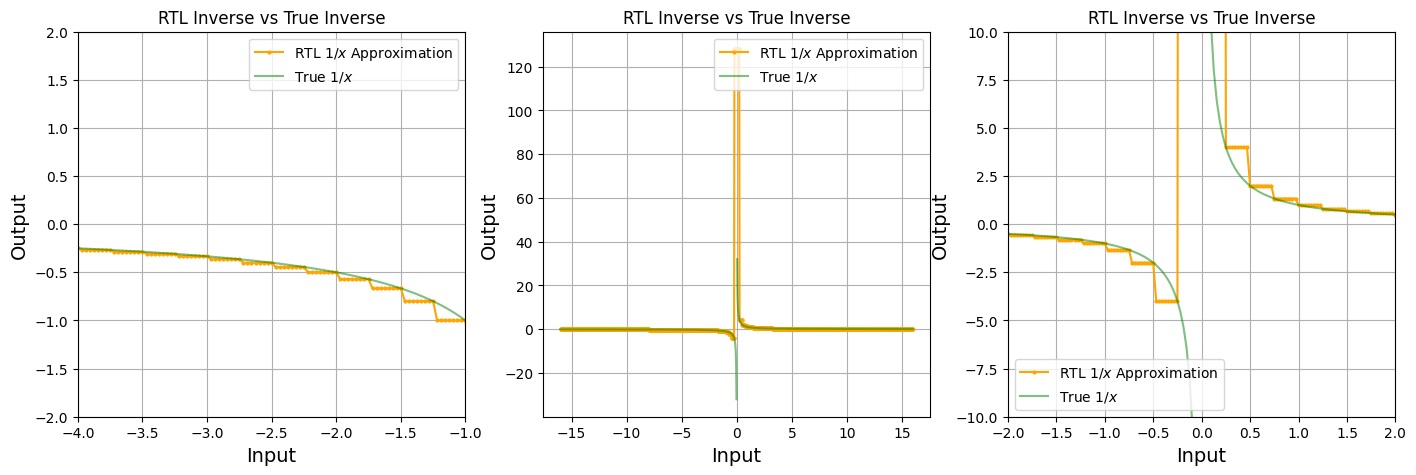

In [43]:
x = np.arange(-2**9, 2**9)
x = x * 2 ** 5
y_inv = [inv_rom.lookup(int(i), debug=True) for i in x]

print("last value", y_inv[-1])

x_proper = x / (2**10)
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

# Plot with adjusted x and y limits
axs[0].plot(x_proper, y_inv, label=r"RTL $1/x$ Approximation", marker="o", markersize=2, color='orange')
axs[0].plot(x_proper, 1 / (x_proper), label=r"True $1/x$", color="green", alpha=0.5)
axs[0].legend()
axs[0].set_title("RTL Inverse vs True Inverse")
axs[0].grid()
axs[0].set_ylim(-2, 2)
axs[0].set_xlim(-4, -1)
axs[0].set_xlabel("Input", fontsize=14)
axs[0].set_ylabel("Output", fontsize=14)
# make axis names fonts larger

# Plot with adjusted x and y limits
axs[1].plot(x_proper, y_inv, label=r"RTL $1/x$ Approximation", marker="o", markersize=2, color='orange')
axs[1].plot(x_proper, 1 / (x_proper), label=r"True $1/x$", color="green", alpha=0.5)
# axs[1].legend()
axs[1].legend(loc='upper right')
axs[1].set_title("RTL Inverse vs True Inverse")
axs[1].grid()
# axs[1].set_ylim(-2, 2)
# axs[1].set_xlim(-4, -1)
axs[1].set_xlabel("Input", fontsize=14)
axs[1].set_ylabel("Output", fontsize=14)

# Plot with adjusted x and y limits
axs[2].plot(x_proper, y_inv, label=r"RTL $1/x$ Approximation", marker="o", markersize=2, color='orange')
axs[2].plot(x_proper, 1 / (x_proper), label=r"True $1/x$", color="green", alpha=0.5)
axs[2].legend()
axs[2].set_title("RTL Inverse vs True Inverse")
axs[2].grid()
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-10, 10)
axs[2].set_xlabel("Input", fontsize=14)
axs[2].set_ylabel("Output", fontsize=14)

fig.savefig("scripts/output/rom_invert.png", dpi=300, bbox_inches='tight')

[DEBUG] input_val: 65369
[DEBUG] input_val (binary): 1111111101011001
[DEBUG] addr: 1021
[DEBUG] addr (binary): 1111111101
[DEBUG] rom_val (raw): 51
[DEBUG] result: 0.0498046875
HELLO
Input value (fixed-point): -0.1630859375
Output value (float): 0.0498046875



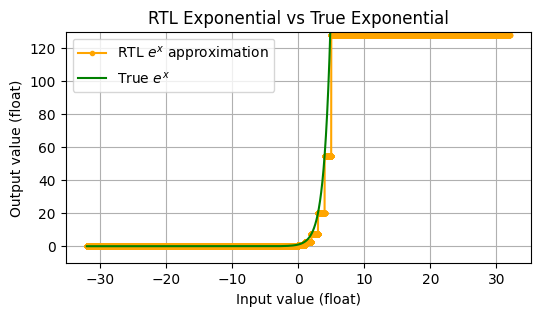

In [32]:
def load_rom_from_dat(filepath: str, data_fmt="18_10", signed=False) -> list[int]:
    """Load ROM from .dat file where each line is a signed/unsigned integer."""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    rom = []
    for line in lines:
        # Remove whitespace and comments
        line = line.split('//')[0].strip()
        if not line:
            continue
        # Convert to integer
        val = int(line, 16)
        # Convert to signed fixed-point if needed
        if signed:
            if val & (1 << (int(data_fmt.split('_')[0]) - 1)):
                val -= (1 << int(data_fmt.split('_')[0]))
        rom.append(val)
    return rom

# def lookup(input_val: int, rom: list[int], shift_amount=6) -> float:
#     """
#     input_val: signed 16_10 fixed-point integer
#     rom: list of 1024 signed 18_10 fixed-point values
#     """
#     # Step 1: Shift to convert 16_10 -> 10_4 signed fixed-point
#     signed_addr = input_val >> shift_amount

#     # Step 2: Reinterpret signed 10-bit as unsigned index
#     rom_index = signed_addr & 0x3FF

#     # Step 3: Lookup in ROM and convert to float
#     rom_val = rom[rom_index]
#     return signed_fixed_to_float(rom_val, nfrac=10, nbits=18)
def lookup(input_val: int, rom: list[int], input_data_fmt="16_10", address_fmt="10_4", table_data_fmt="18_10", table_data_signed=False, debug=False) -> float:
    """
    Simulates a fixed-point lookup table read (like for exp or reciprocal ROMs).

    Parameters:
    - input_val: Fixed-point integer input to look up.
    - rom: List of ROM values (integers).
    - input_data_fmt: Format of input fixed-point number as "total_frac", e.g. "16_10" means 16 total bits, 10 fractional.
    - address_fmt: Format of the ROM address as "total_frac", e.g. "10_4" means 10-bit address, with 4 fractional bits.
    - table_data_signed: Whether the data in ROM is signed.
    - debug: If True, print intermediate info.

    Returns:
    - float: The floating-point representation of the looked-up value.
    """
    import math

    # Parse formats
    in_total, in_frac = map(int, input_data_fmt.split('_'))
    addr_total, addr_frac = map(int, address_fmt.split('_'))
    table_total, table_frac = map(int, table_data_fmt.split('_'))
    

    # # Convert input_val to address by shifting right to discard LSBs
    addr = (input_val >> (in_frac - addr_frac)) & ((1 << addr_total) - 1)
    
    # addr = input_val >> (in_frac - addr_frac)

    if addr >= len(rom):
        raise IndexError(f"Address {addr} out of ROM bounds (ROM size: {len(rom)})")

    rom_val = rom[addr]
    
    # Convert ROM value to signed fixed-point
    # If the ROM value is negative, we need to convert it to signed fixed-point
    # by subtracting 2^table_total
    if table_data_signed:
        if rom_val & (1 << (table_total - 1)):
            rom_val -= (1 << table_total)
    else:
        # If the ROM value is unsigned, we need to reinterpret it as signed
        # by masking with (1 << table_total) - 1
        rom_val &= (1 << table_total) - 1
    # Convert ROM value to float

    # # Interpret as signed if needed
    if table_data_signed:
        rom_val = rom_val - (1 << (addr_total)) if rom_val & (1 << (addr_total - 1)) else rom_val

    # Convert ROM output to float assuming full scale is 1 << addr_frac
    result = rom_val / (2.0 ** table_frac)

    if debug:
        print(f"[DEBUG] input_val: {input_val}")
        print(f"[DEBUG] input_val (binary): {input_val:0{in_total}b}")
        print(f"[DEBUG] addr: {addr}")
        print(f"[DEBUG] addr (binary): {addr:0{addr_total}b}")
        print(f"[DEBUG] rom_val (raw): {rom[addr]}")
        # print(f"[DEBUG] rom_val (signed): {rom_val}")
        print(f"[DEBUG] result: {result}")

    return result


filepath = "/home/donovan/code/research/hls4ml/waiz-khan-files/model_7/16_10_prj/myproject_prj/solution1/impl/verilog/softmax_stable_ap_fixed_ap_fixed_16_10_5_3_0_softmax_config16_s_exp_table1_rom.dat"

rom = load_rom_from_dat(filepath)

# Example input value
for input_val in [
    # 0b00_10000_00000,
    # 0b00_01000_00001,
    # 0b00_00010_00001,
    0xFF59,
    ]:
    # Perform lookup directly with the integer input value
    output_val = lookup(input_val, rom, address_fmt="10_4", table_data_fmt="18_10", table_data_signed=False, debug=True)
    print(f"Input value (fixed-point): {fixed_to_float(input_val, nfrac=10, nbits=16, signed=True)}")
    print(f"Output value (float): {output_val}")
    print()



# Now plot this for all possible values representable by signed 16_10
# also include the real exp function for comparison
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-32768, 32768)  # Adjusted range to include all representable values
y = np.array([lookup(val, rom, address_fmt="10_0", table_data_fmt="18_10", table_data_signed=False) for val in x])

# Convert fixed-point x values to float for comparison
x_float = x / (1 << 10)
y_true = np.exp(x_float)  # True exponential values

x_0_to_50 = np.arange(0, 50)

plt.figure(figsize=(6, 3))
plt.plot(x_float, y, label=r"RTL $e^x$ approximation", color="orange", marker=".")
plt.plot(x_float, y_true, label=r"True $e^x$", color="green")
# plt.plot(x_0_to_50, np.exp(x_0_to_50), 'o--', label="True exp (0 to 50)")

# add a point for x=4
# plt.plot(4, np.exp(4), 'go', label="True exp at x=4")
plt.legend()
plt.title("RTL Exponential vs True Exponential")
plt.xlabel("Input value (float)")
plt.ylabel("Output value (float)")
# plt.xlim(-2.5, 5)
plt.ylim(-10, 130)
plt.grid()
plt.savefig("scripts/output/rtl_exp_vs_true_exp.png", dpi=300, bbox_inches='tight')
plt.show()

In [80]:
fixed = "045C"
output = "40031"
print(f"Fixed point value in float: {signed_fixed_to_float(int(fixed, 16), nfrac=10, nbits=16)}")
# exponentiate using table
print(f"Exponentiated value using table: {lookup(int("10", 16), rom)}")
print(f"model sim output: {signed_fixed_to_float(int(output, 16), nfrac=10, nbits=18)}")

SyntaxError: f-string: unmatched '(' (2976607316.py, line 5)

In [21]:
number = 127.9990234375 * 2 + 0.0498046875
print(f"Number: {number}")

Number: 256.0478515625


In [79]:
temp_sum = "40031"
temp_sum = signed_fixed_to_float(int(temp_sum, 16), nfrac=10, nbits=18)
print(f"temp_sum: {temp_sum}")
exp_sum = "14"

exp_sum = signed_fixed_to_float(int(exp_sum, 16), nfrac=2, nbits=10)
print(f"exp_sum: {exp_sum}")

temp_sum: 256.0478515625
exp_sum: 5.0


In [42]:
sixteen_bit_fixed = "08"
print(f"16-bit fixed point value: {signed_fixed_to_float(int(sixteen_bit_fixed, 16), nfrac=10, nbits=18)}")

16-bit fixed point value: 0.0078125


In [68]:
print(127.9990234375 * 0.0078125)

0.9999923706054688


## Invert Table

In [13]:
inv_filepath = '/home/donovan/code/research/hls4ml/waiz-khan-files/model_7/16_10_prj/myproject_prj/solution1/impl/verilog/softmax_stable_ap_fixed_ap_fixed_16_10_5_3_0_softmax_config16_s_invert_table2_rom.dat'
inv_rom = load_rom_from_dat(inv_filepath)
# Example input value

invert_index = "1ff"
invert_index = int(invert_index, 16)
print(f"Lookup index: {invert_index}")
invert = lookup(invert_index, inv_rom, shift_amount=0)
print(f"Lookup value: {invert}")

Lookup index: 511
Lookup value: 0.12890625


In [14]:
lookup(2 << 10, inv_rom, shift_amount=8)

127.9990234375

/tmp/ipykernel_12459/2584941588.py:6: RuntimeWarning: divide by zero encountered in divide
  y_true = 1 / x_float  # True inverse values


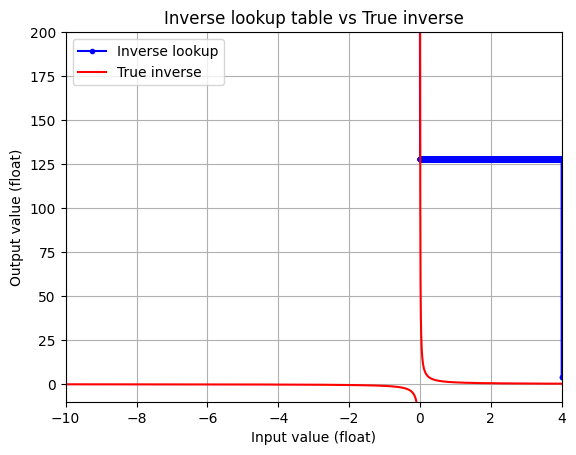

In [15]:
# x = np.arange(-32768, 32768)  # Adjusted range to include all representable values
y_inv = np.array([lookup(val, inv_rom, shift_amount=8) for val in x])

# Convert fixed-point x values to float for comparison
x_float = x / (1 << 10)
y_true = 1 / x_float  # True inverse values

plt.plot(x_float, y_inv, label="Inverse lookup", color="blue", marker=".")
plt.plot(x_float, y_true, label="True inverse", color="red")
plt.legend()
plt.title("Inverse lookup table vs True inverse")
plt.xlabel("Input value (float)")
plt.ylabel("Output value (float)")
plt.ylim(-10, 200)
plt.xlim(-10, 4)
plt.grid()
plt.show()

In [66]:
number = "FF59"
print(f"16-bit fixed point value: {signed_fixed_to_float(int(number, 16), nfrac=10, nbits=16)}")

16-bit fixed point value: -0.1630859375
